# CREDENTIAL RISK ASSESSMENT

## LOADING DEPENDENCY

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency

## LOADING FILES AND EXPLORATION

In [ ]:
credit_data = pd.read_csv("credit_risk_dataset_v.csv", sep=',', header=0, on_bad_lines='skip')

In [ ]:
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## EDA PHASE BEGINS

In [ ]:
credit_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [ ]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


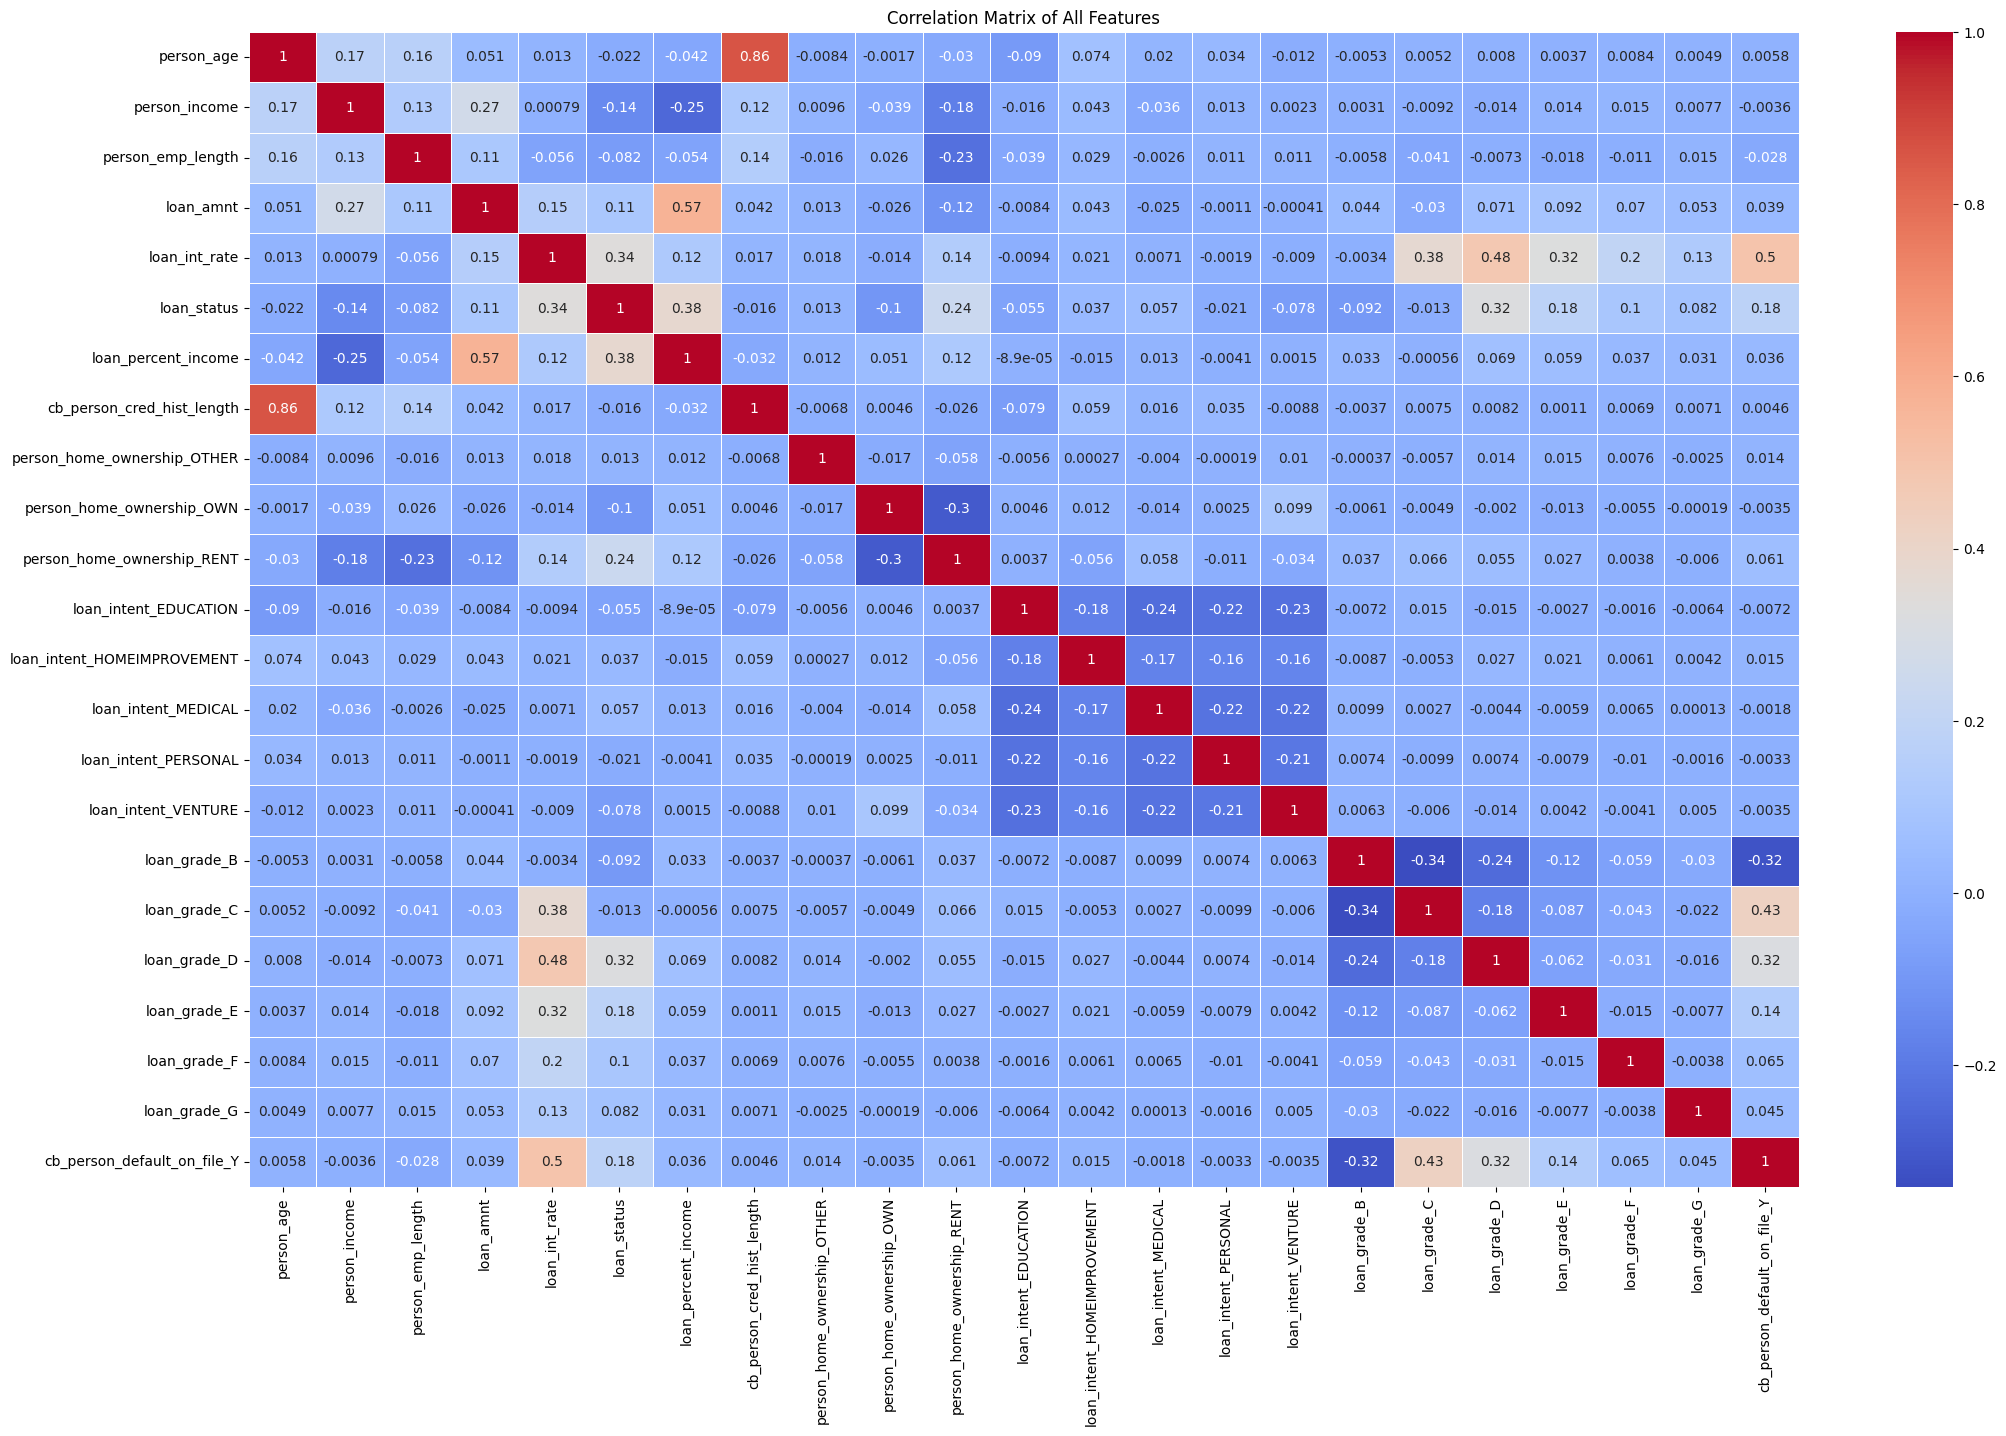

In [ ]:
credit_data_encoded = pd.get_dummies(credit_data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

correlation_matrix = credit_data_encoded.corr()

plt.figure(figsize=(25,15))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of All Features')
plt.show()

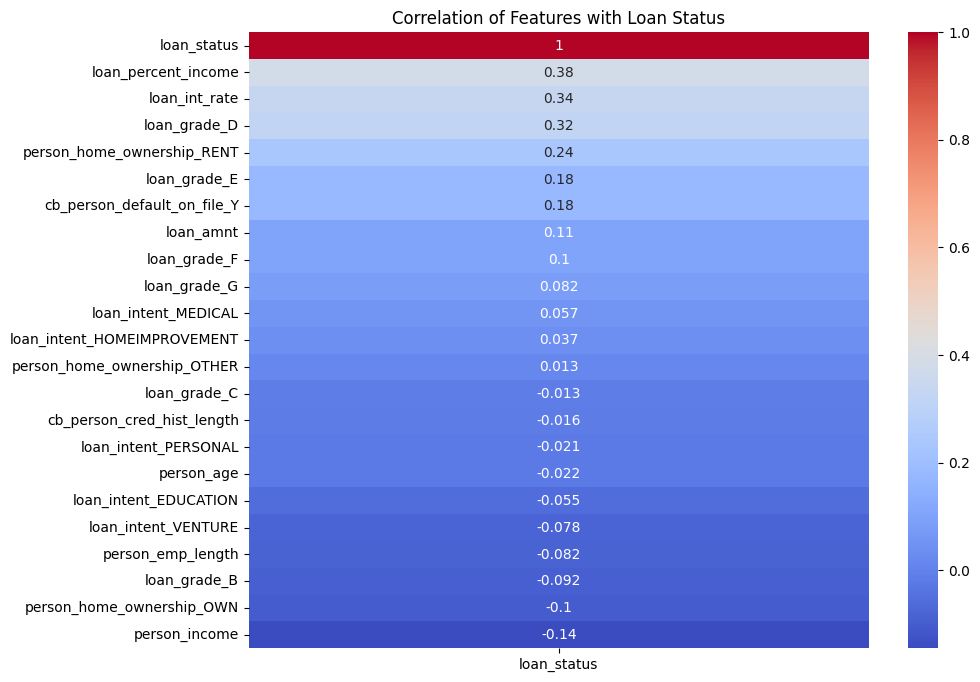

In [ ]:
credit_data_encoded = pd.get_dummies(credit_data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'], drop_first=True)

correlation_matrix = credit_data_encoded.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix[['loan_status']].sort_values(by='loan_status', ascending=False), annot=True, cmap='coolwarm')

plt.title('Correlation of Features with Loan Status')
plt.show()

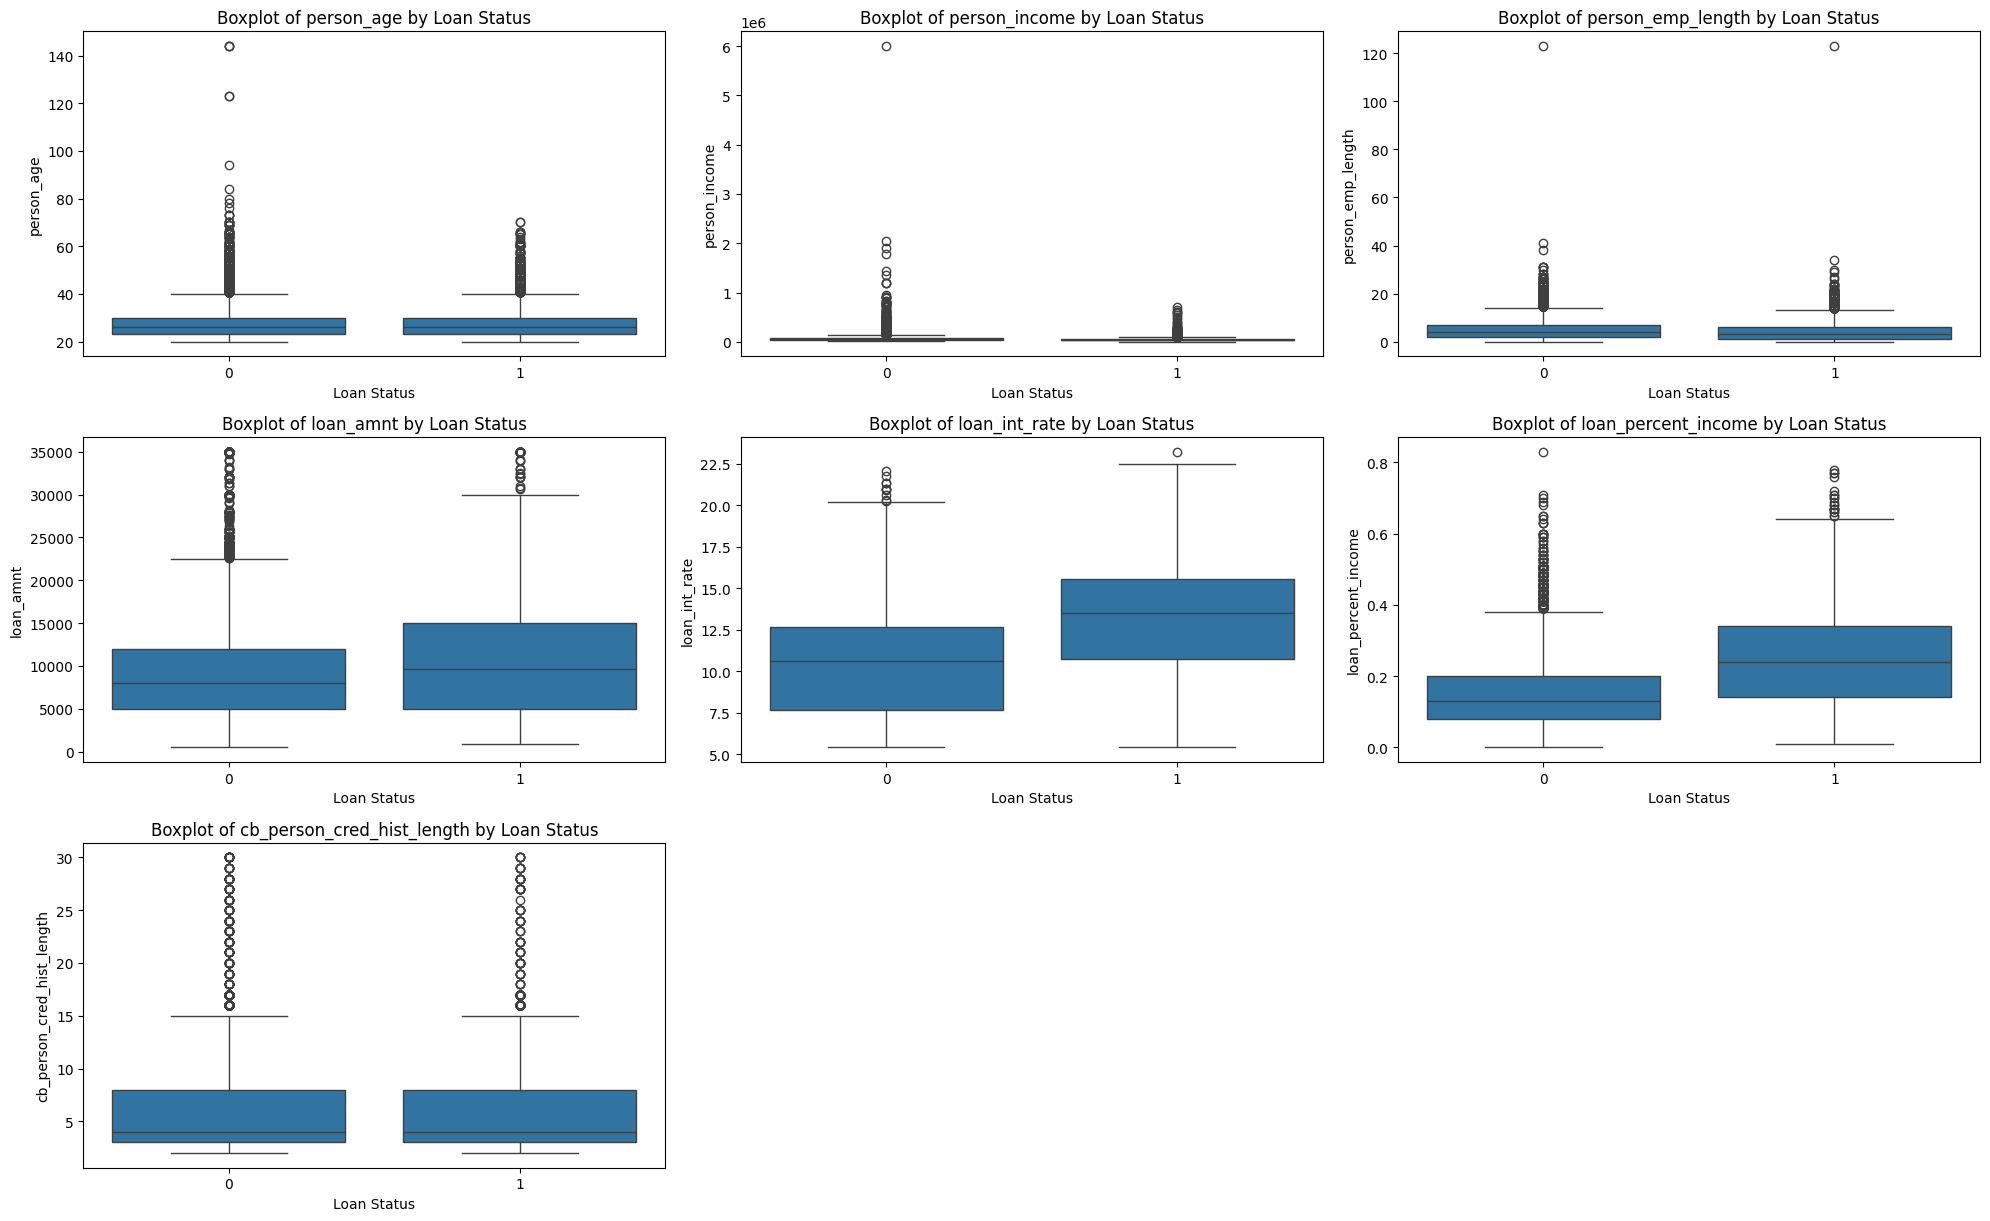

In [ ]:
columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

plt.figure(figsize=(20,20))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 3, i)  # Adjust the grid size if needed
    sns.boxplot(x='loan_status', y=column, data=credit_data)
    plt.title(f'Boxplot of {column} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [ ]:
def remove_rows_based_on_iqr(df, include_cols, iqr_threshold):
    df_cleaned = df.copy()

    for col in include_cols:
        if col in df_cleaned.columns and df_cleaned[col].dtype in ['int64', 'float64']:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - iqr_threshold * IQR
            upper_bound = Q3 + iqr_threshold * IQR

            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned


include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
credit_df_cleaned = remove_rows_based_on_iqr(credit_data, include_cols=include_columns, iqr_threshold=2.5)
credit_df_cleaned

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32290,37,90000,MORTGAGE,11.0,DEBTCONSOLIDATION,A,4000,6.62,0,0.04,N,15
32293,38,110000,MORTGAGE,5.0,MEDICAL,B,16000,11.99,0,0.15,N,13
32294,36,92000,MORTGAGE,18.0,DEBTCONSOLIDATION,A,4000,7.29,0,0.04,N,13
32295,42,101000,MORTGAGE,6.0,DEBTCONSOLIDATION,F,25000,16.15,1,0.25,Y,14


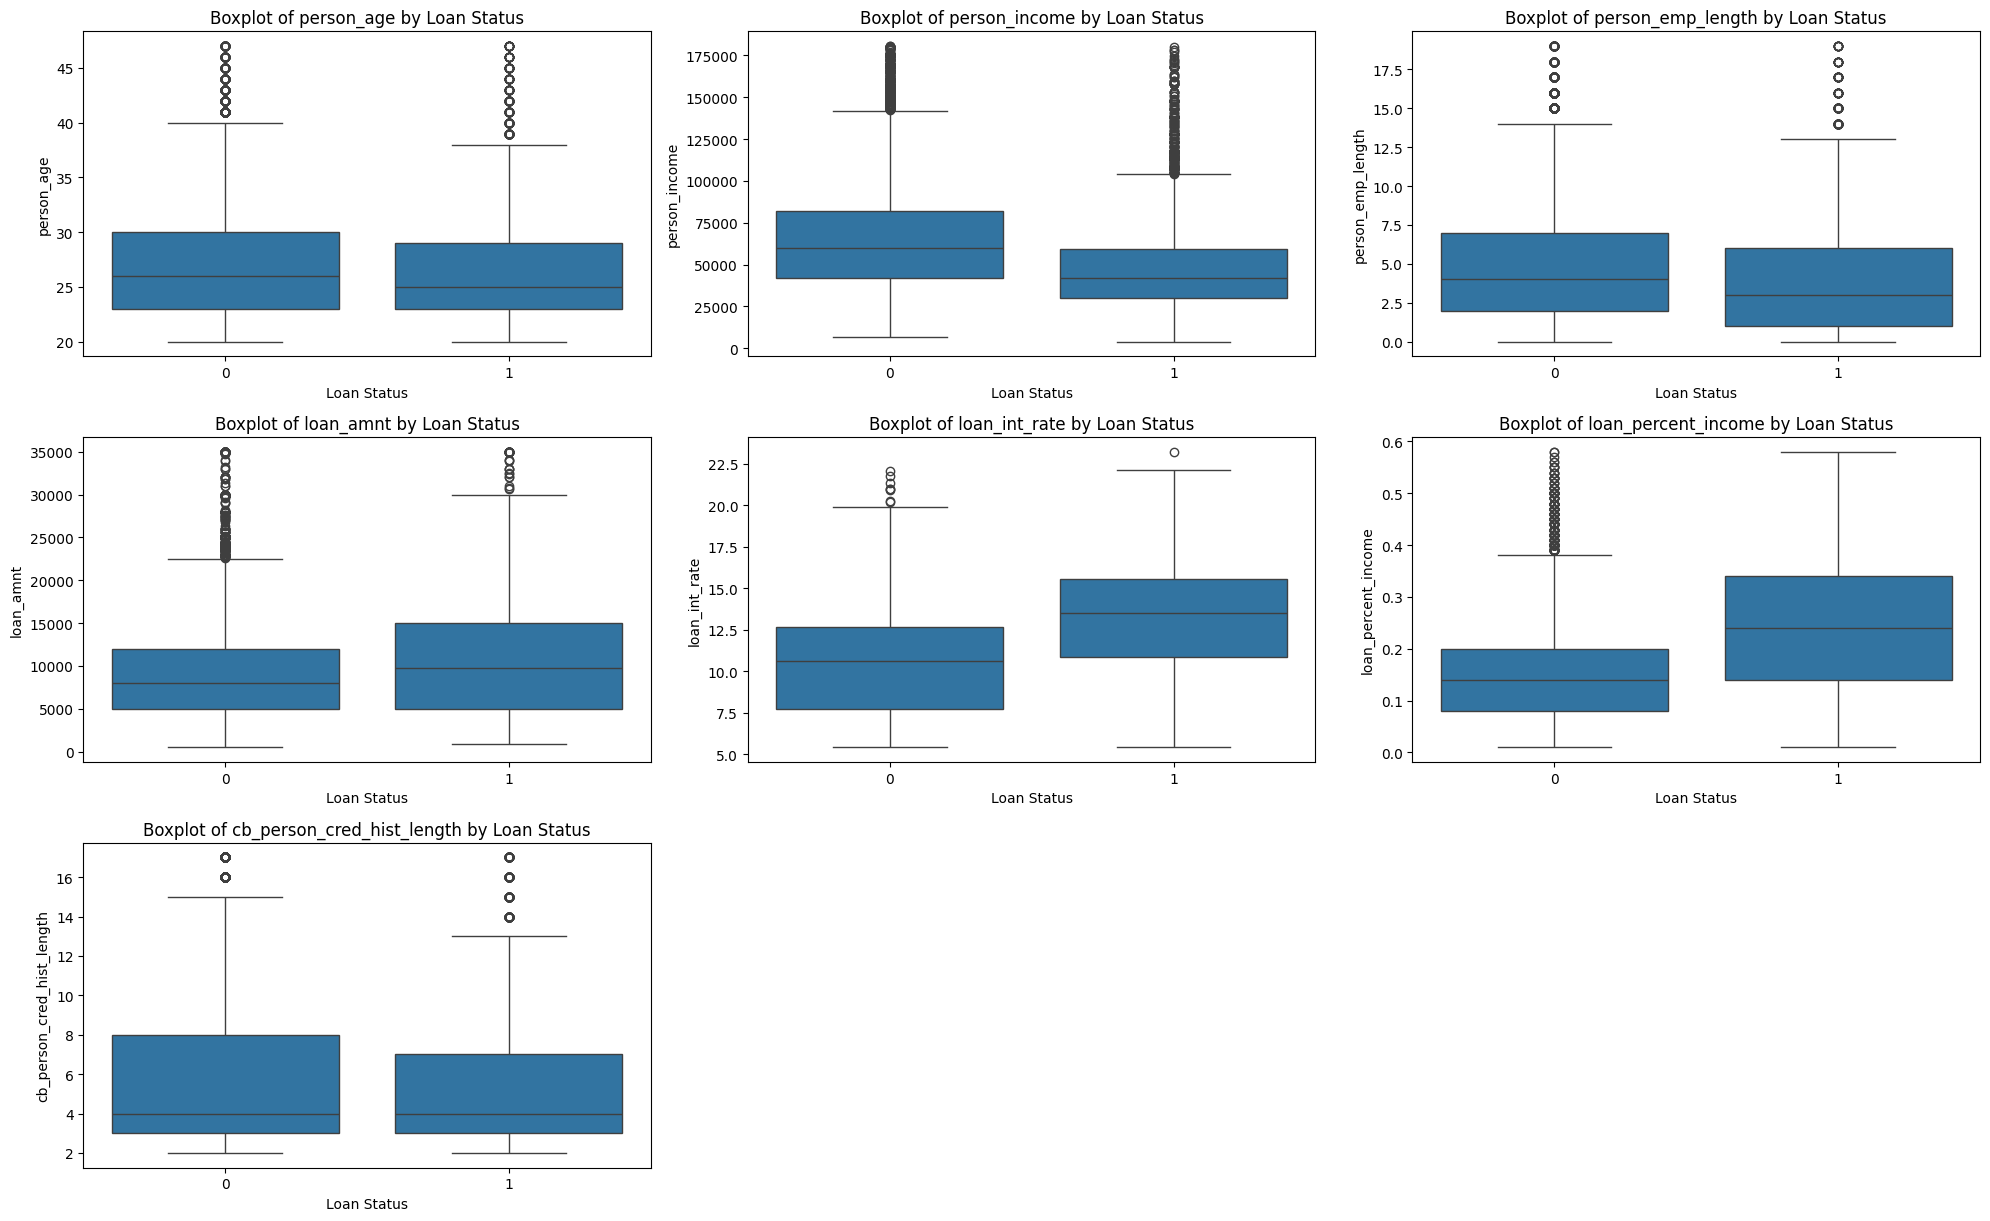

In [ ]:
columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length']

plt.figure(figsize=(20,20))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(x='loan_status', y=column, data=credit_df_cleaned)
    plt.title(f'Boxplot of {column} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

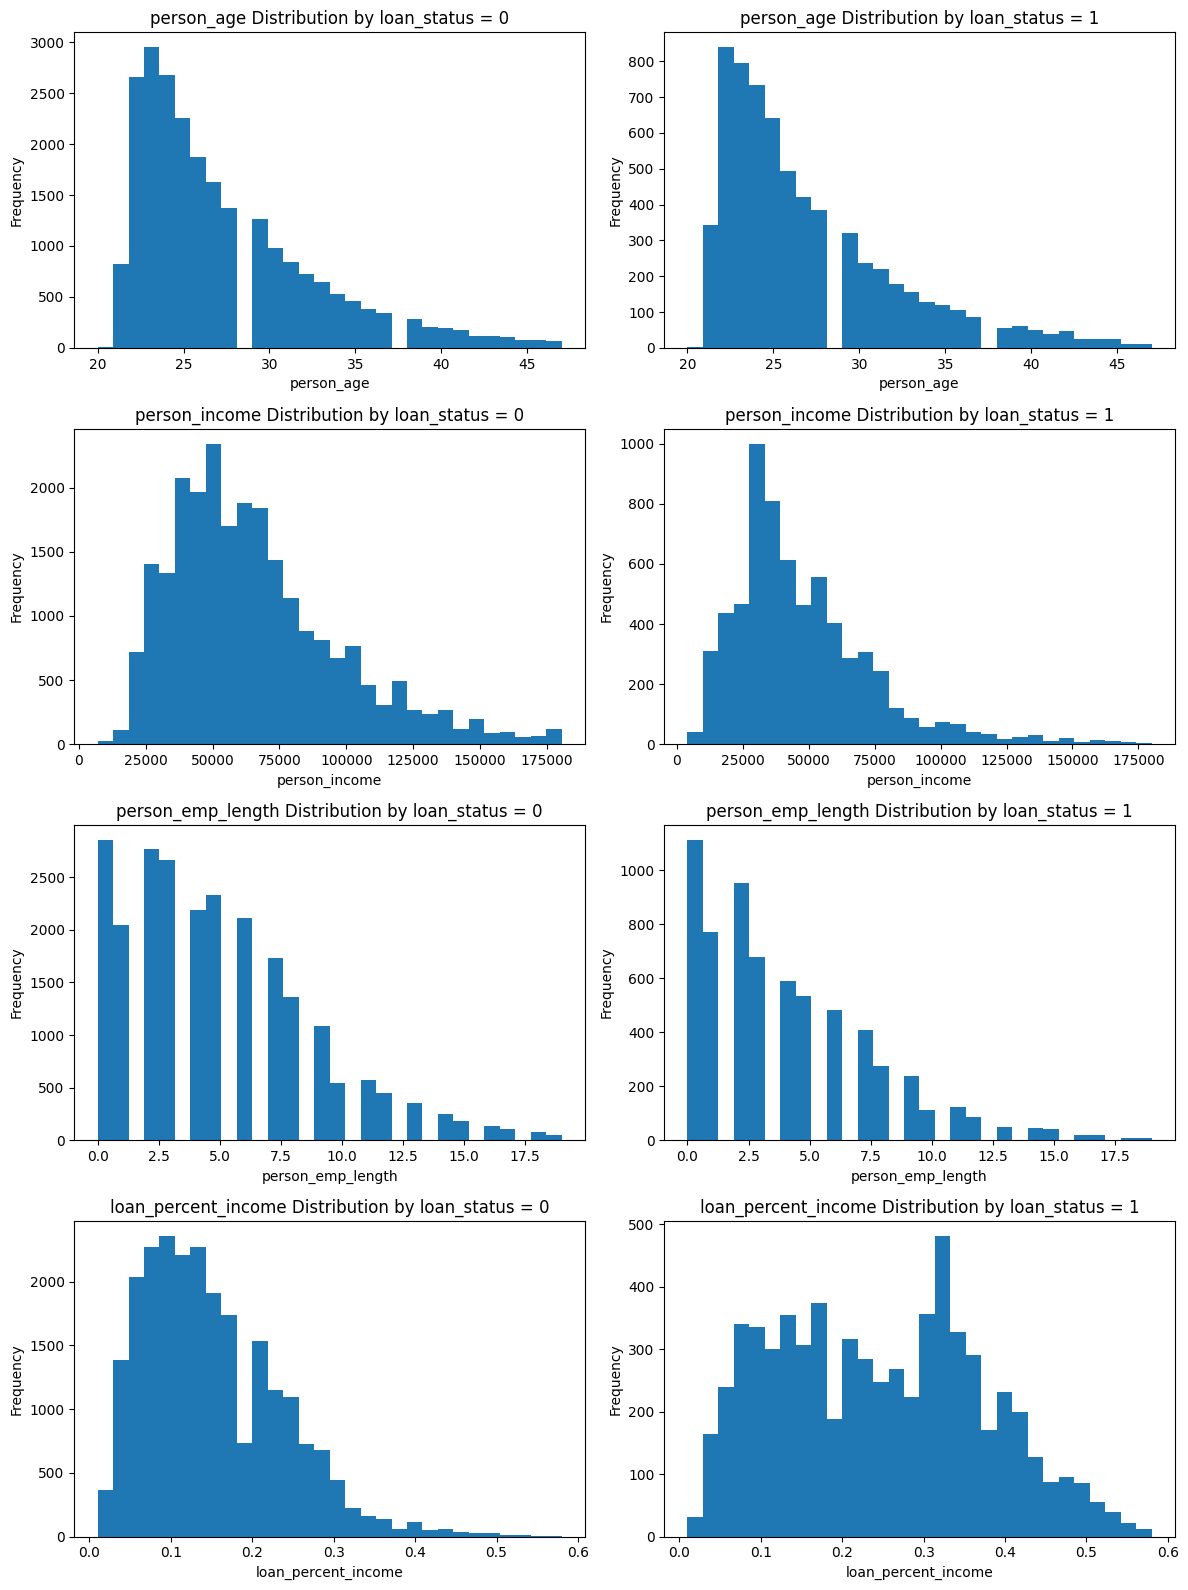

In [ ]:
def plot_histograms(df, target_col, feature_cols):
    num_features = len(feature_cols)

    # Create a subplot for each feature
    fig, axes = plt.subplots(num_features, 2, figsize=(12, num_features * 4))

    if num_features == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, col in enumerate(feature_cols):
        # Plot histogram for target == 0
        df[df[target_col] == 0][col].plot(kind='hist', ax=axes[i][0], title=f'{col} Distribution by {target_col} = 0', bins=30)
        axes[i][0].set_xlabel(col)

        # Plot histogram for target == 1
        df[df[target_col] == 1][col].plot(kind='hist', ax=axes[i][1], title=f'{col} Distribution by {target_col} = 1', bins=30)
        axes[i][1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
plot_histograms(credit_df_cleaned, 'loan_status', include_columns)

In [ ]:
def apply_log_transformation(df, include_cols):
    df_transformed = df.copy()

    for col in include_cols:
        if col in df_transformed.columns and df_transformed[col].dtype in ['int64', 'float64']:
            df_transformed[col] = df_transformed[col].apply(lambda x: np.log(x) if x > 0 else np.nan)

    return df_transformed

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
credit_df_transformed = apply_log_transformation(credit_data, include_cols=include_columns)
credit_df_transformed

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,3.091042,10.985293,RENT,4.812184,PERSONAL,D,35000,16.02,1,-0.527633,Y,3
1,3.044522,9.169518,OWN,1.609438,EDUCATION,B,1000,11.14,0,-2.302585,N,2
2,3.218876,9.169518,MORTGAGE,0.000000,MEDICAL,C,5500,12.87,1,-0.562119,N,3
3,3.135494,11.089805,RENT,1.386294,MEDICAL,C,35000,15.23,1,-0.634878,N,2
4,3.178054,10.904119,RENT,2.079442,MEDICAL,C,35000,14.27,1,-0.597837,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.043051,10.878047,MORTGAGE,0.000000,PERSONAL,C,5800,13.16,0,-2.207275,N,30
32577,3.988984,11.695247,MORTGAGE,1.386294,PERSONAL,A,17625,7.49,0,-1.897120,N,19
32578,4.174387,11.238489,RENT,1.098612,HOMEIMPROVEMENT,B,35000,10.99,1,-0.776529,N,28
32579,4.025352,11.918391,MORTGAGE,1.609438,PERSONAL,B,15000,11.48,0,-2.302585,N,26


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming X and y have already been defined as the feature set and target variable

# Step 1: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Save the resulting splits to CSV files
X_train.to_csv('X_train.csv', index=False)  # Features for training set
X_test.to_csv('X_test.csv', index=False)    # Features for test set
y_train.to_csv('y_train.csv', index=False)  # Target for training set
y_test.to_csv('y_test.csv', index=False)    # Target for test set

print("Training and testing data saved to CSV files.")


NameError: name 'X' is not defined

Training and testing data saved to CSV files.
Accuracy: 0.8583
Precision: 0.7430
Recall: 0.5443
ROC AUC: 0.7456

Confusion Matrix:
[[6737  378]
 [ 915 1093]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7115
           1       0.74      0.54      0.63      2008

    accuracy                           0.86      9123
   macro avg       0.81      0.75      0.77      9123
weighted avg       0.85      0.86      0.85      9123



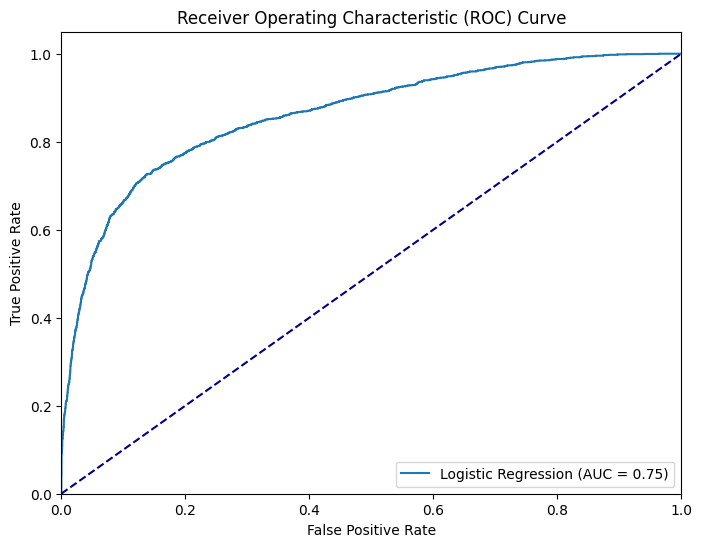

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# Step 1: Prepare the data (assuming 'credit_df_cleaned' is already defined and cleaned)
X = pd.get_dummies(credit_df_cleaned.drop(columns=['loan_status']), drop_first=True)  # One-hot encode categorical columns
y = credit_df_cleaned['loan_status']

# Step 2: Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns  # Corrected 'Cinclude' to 'include'
categorical_cols = X.select_dtypes(include=['object']).columns

# Step 3: Impute missing values
# Impute missing values for numerical columns (using mean)
numerical_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

# Impute missing values for categorical columns (using most frequent)
if len(categorical_cols) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Step 4: Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Step 5: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Save the resulting splits to CSV files
X_train.to_csv('X_train.csv', index=False)  # Features for training set
X_test.to_csv('X_test.csv', index=False)    # Features for test set
y_train.to_csv('y_train.csv', index=False)  # Target for training set
y_test.to_csv('y_test.csv', index=False)    # Target for test set

print("Training and testing data saved to CSV files.")

# Step 7: Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Step 8: Train the model
log_reg_model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Step 11: Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 12: Optional - Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


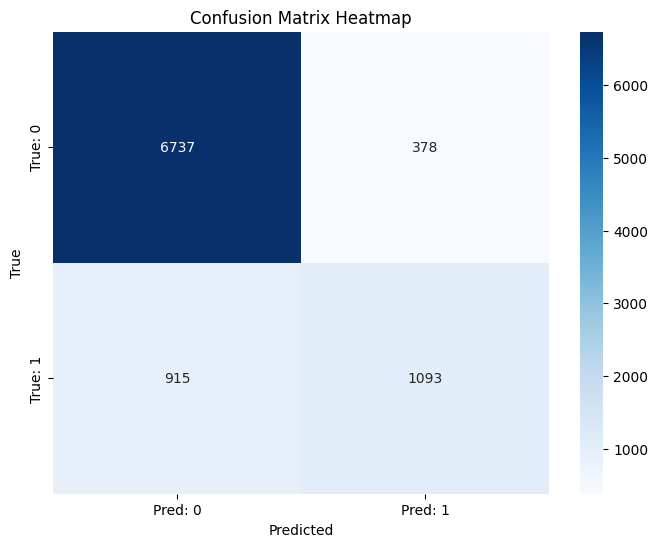

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


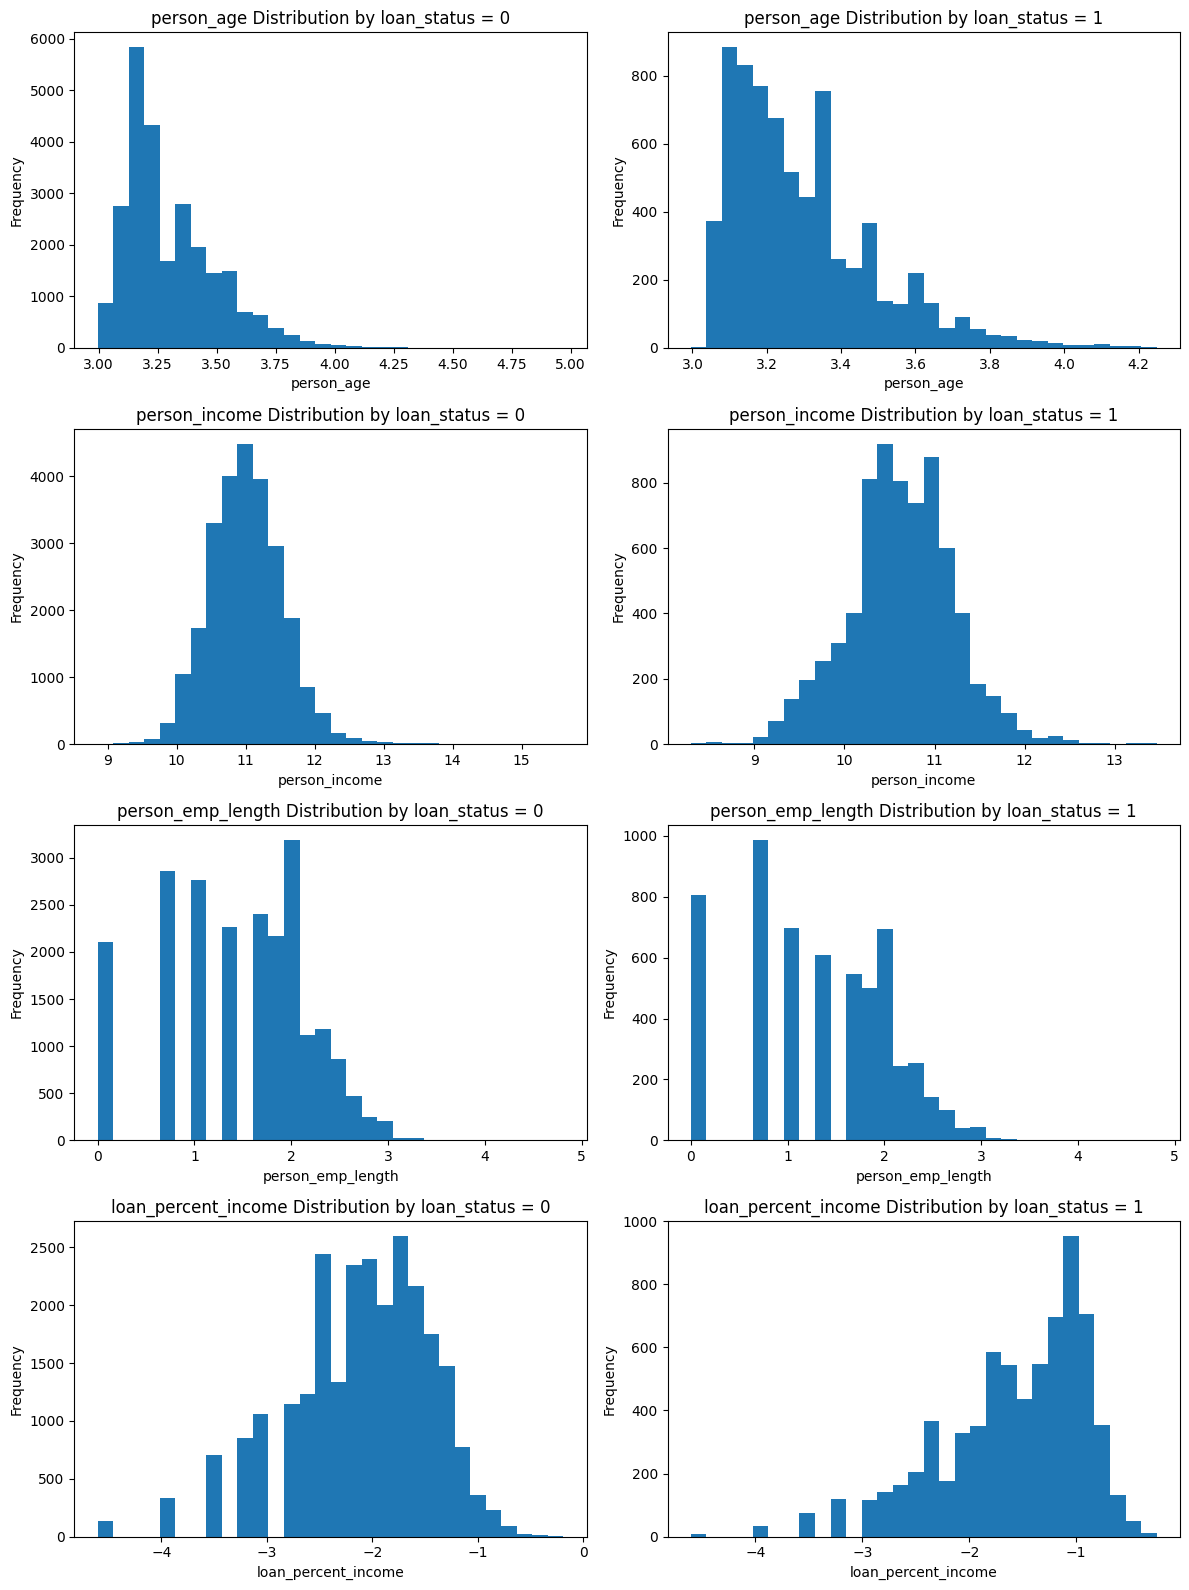

In [ ]:
def plot_histograms(df, target_col, feature_cols):
    num_features = len(feature_cols)

    # Create a subplot for each feature
    fig, axes = plt.subplots(num_features, 2, figsize=(12, num_features * 4))

    if num_features == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, col in enumerate(feature_cols):
        # Plot histogram for target == 0
        df[df[target_col] == 0][col].plot(kind='hist', ax=axes[i][0], title=f'{col} Distribution by {target_col} = 0', bins=30)
        axes[i][0].set_xlabel(col)

        # Plot histogram for target == 1
        df[df[target_col] == 1][col].plot(kind='hist', ax=axes[i][1], title=f'{col} Distribution by {target_col} = 1', bins=30)
        axes[i][1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

# Example usage
include_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_percent_income']
plot_histograms(credit_df_transformed, 'loan_status', include_columns)

In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

## TESTING SOME HYPOTHESIS FOR EDA

![image.png](attachment:874736ba-0a1d-4e79-91d9-b77732933e81.png)

In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [ ]:
len(credit_df_cleaned[credit_df_cleaned['loan_status'] == 1]),len(credit_df_cleaned[credit_df_cleaned['loan_status'] == 0])

(6559, 23850)

### HYPOTHESIS FORMULATION AND STUDY

#### Hypothesis 1: Older applicants are less likely to default on their loans compared to younger applicants


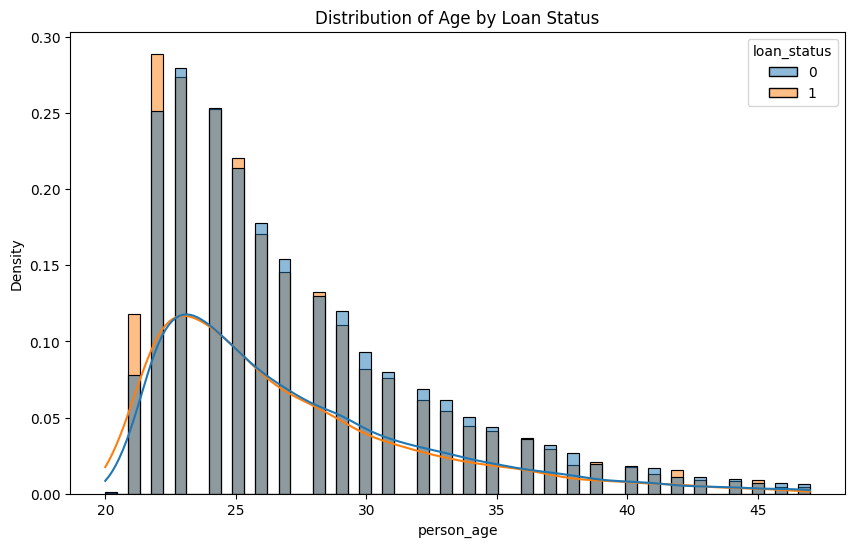

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_age', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Age by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_age'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Age and loan default status.")
else:
    print("There is no statistically significant relationship between Age and loan default status.")

Chi-square statistic: 89.22678631664849
P-value: 1.4053063610029427e-08
Degrees of freedom: 27
There is a statistically significant relationship between Age and loan default status.


Interpretation of Hypothesis:
This graph supports the hypothesis that younger borrowers are more likely to default on their loans compared to older borrowers. The density of defaults (orange) is notably higher for younger individuals, particularly around age 20. As borrowers age, the likelihood of default decreases, as indicated by the shrinking orange areas and the increasing density of non-defaults.

#### Hypothesis 2: Applicants who own their homes are less likely to default on their loans


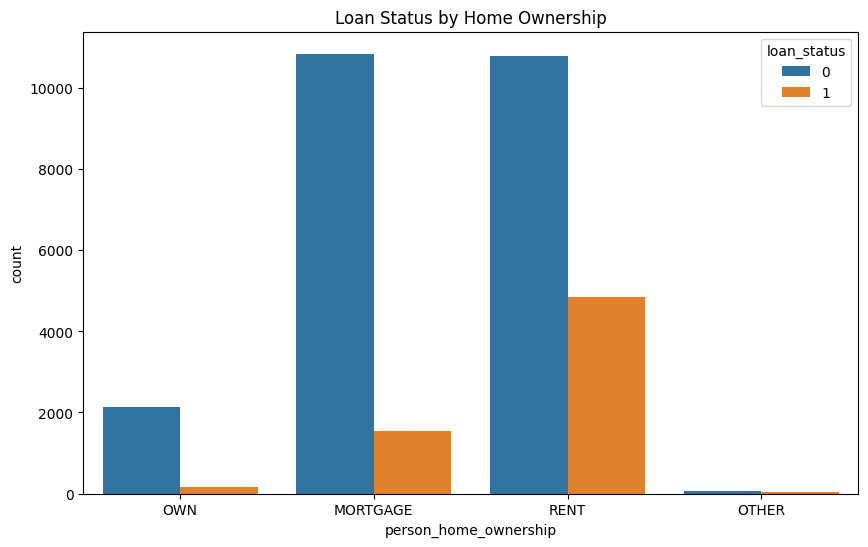

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=credit_df_cleaned, x='person_home_ownership', hue='loan_status')
plt.title('Loan Status by Home Ownership')
plt.show()

In [ ]:
proportions = credit_df_cleaned.groupby('person_home_ownership')['loan_status'].mean()
proportions

person_home_ownership
MORTGAGE    0.123819
OTHER       0.330000
OWN         0.068261
RENT        0.309445
Name: loan_status, dtype: float64

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_home_ownership'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between home ownership and loan default status.")
else:
    print("There is no statistically significant relationship between home ownership and loan default status.")

Chi-square statistic: 1732.9765877707177
P-value: 0.0
Degrees of freedom: 3
There is a statistically significant relationship between home ownership and loan default status.


#### Hypothesis 3: Borrowers with longer employment lengths are less likely to default on their loans


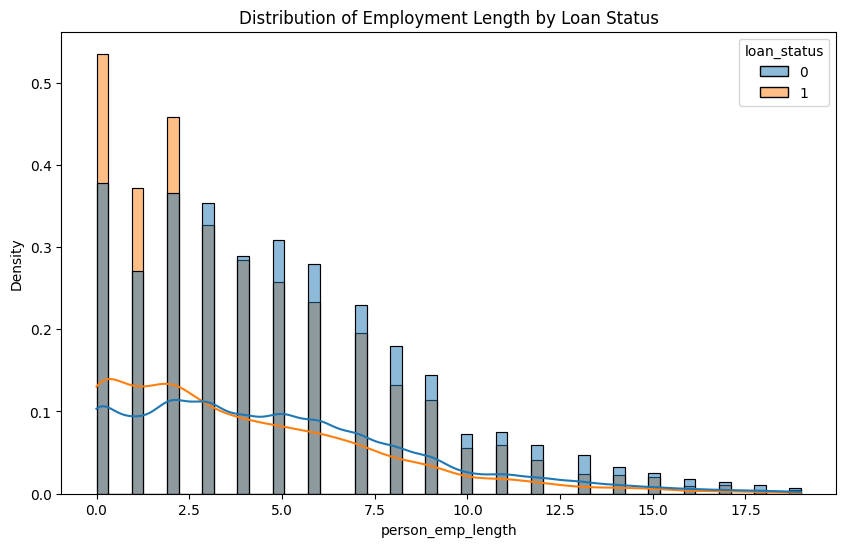

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_emp_length', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Employment Length by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_emp_length'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between employement and loan default status.")
else:
    print("There is no statistically significant relationship between employement and loan default status.")

Chi-square statistic: 330.81772305767447
P-value: 9.284191888919078e-59
Degrees of freedom: 19
There is a statistically significant relationship between employement and loan default status.


#### Hypothesis 4: The intent of the loan affects the likelihood of default

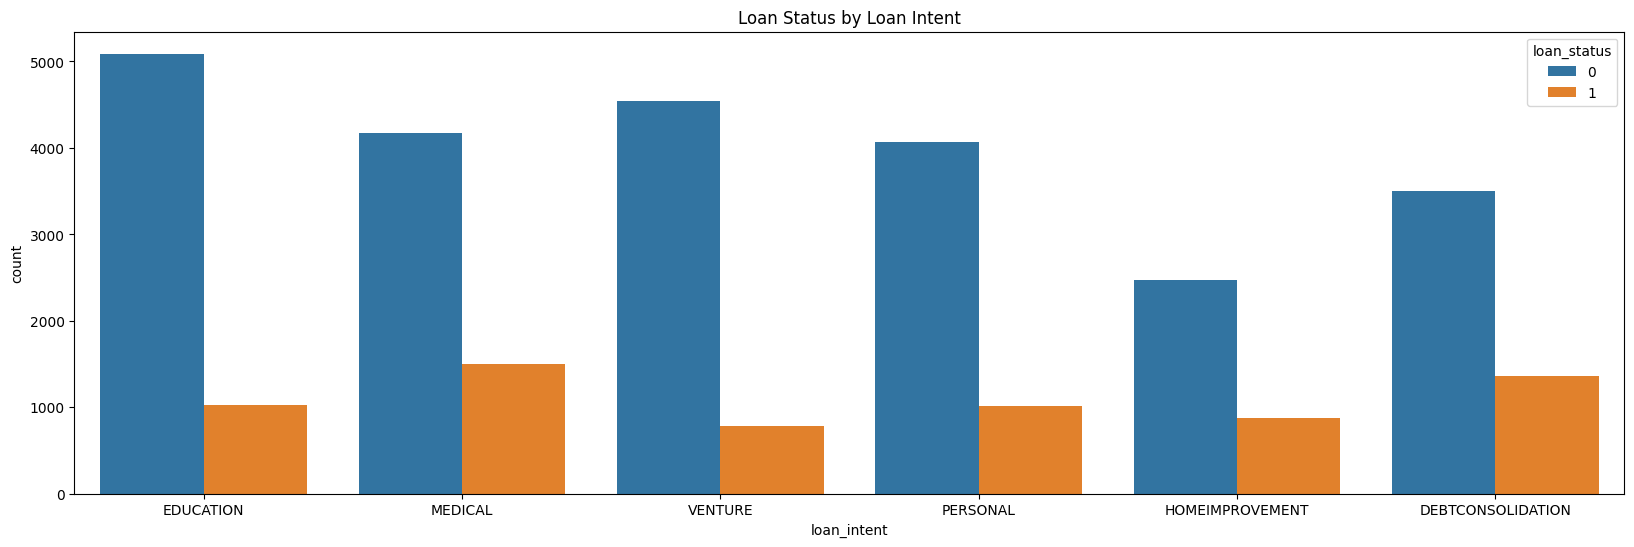

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(data=credit_df_cleaned, x='loan_intent', hue='loan_status')
plt.title('Loan Status by Loan Intent')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['loan_intent'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Loan Intent and loan default status.")
else:
    print("There is no statistically significant relationship between Loan Intent and loan default status.")

Chi-square statistic: 473.00450276889666
P-value: 5.348666821891793e-100
Degrees of freedom: 5
There is a statistically significant relationship between Loan Intent and loan default status.


In [ ]:
credit_df_cleaned.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

#### Hypothesis 5: The personal income wealth affects your chances of getting a loan?

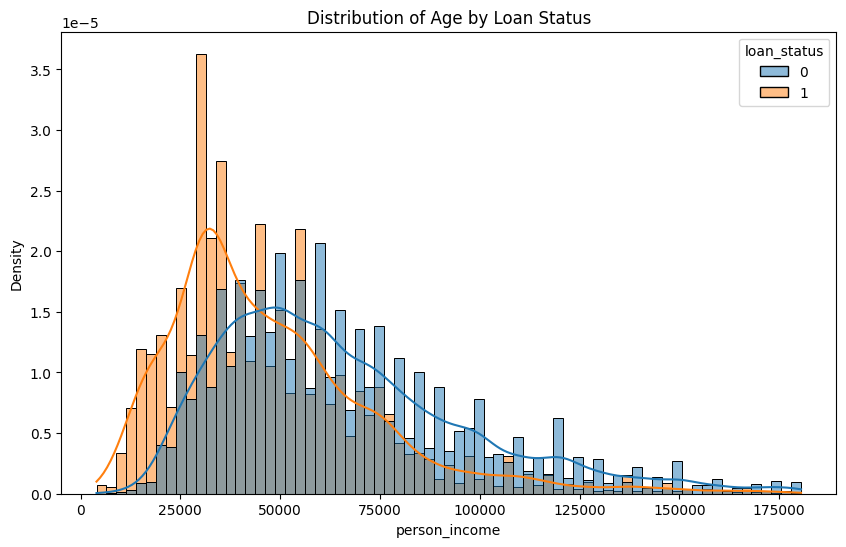

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=credit_df_cleaned, x='person_income', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title('Income as per by Loan Status')
plt.show()

In [ ]:
contingency_table = pd.crosstab(credit_df_cleaned['person_income'], credit_df_cleaned['loan_status'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

if p < 0.05:
    print("There is a statistically significant relationship between Personal Income and loan default status.")
else:
    print("There is no statistically significant relationship between Personal Income and loan default status.")

Chi-square statistic: 10872.371580721127
P-value: 0.0
Degrees of freedom: 3866
There is a statistically significant relationship between Personal Income and loan default status.


#### MODEL SELECTION